In [2]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from scipy.stats import entropy,skew, kurtosis


In [14]:
class AjustesOdds:
    def __init__(self, array1):
        self.array1 = array1

    def coletarodd(self, i, inteiro, data, alavanca=True):
        """
        Função que coleta e organiza as entradas iniciais do banco de dados.
        Args:
            i (int): Valor inteiro não-negativo. Entrada que controla o loop principal. É um valor cumulativo.
            inteiro (int): Valor inteiro não-negativo. Entrada que determina até aonde os dados devem ser carregados automaticamente, através de um banco de dados.
            data (pd.DataFrame): Variável carregada inicialmente para treinamento/desenvolvimento. Do tipo data frame.   #FIXWARNING2
            array2s (np.array): Array cumulativo que carrega as entradas reais com duas casas decimais.
            array2n (np.array): Array cumulativo que carrega as entredas inteiras(0 ou 1).
            alanvanca (bool): Variável booleana que determina se a entrada é automática ou manual.   #FIXWARNING1
        Returns:
            np.array: Array cumulativo que carrega as entradas reais com duas casas decimais.
            np.array: Array cumulativo que carrega as entredas inteiras(0 ou 1).
            float: Valor real com duas casas decimais. Ele é determinado pela entrada dos dados, ou usuário.
        """

    #FIXWARNING1: O formato da data de entrada pode ser mudado? Atualmente está em .csv

        if i <= inteiro:
            if alavanca == True:
                odd = float(data['Entrada'][i].replace(",",'.'))
            else:
                odd = data['Entrada'][i] 

            if odd == 0:
                odd = 1
            #print(f'Entrada: {odd}')
        else:
            odd = float(input("Entrada -> ").replace(",",'.'))

        if odd == 0:
            return self.array1, odd

        self.array1.append(odd)
        return self.array1, odd

    def dual_fuzzy_classification_invertida(self, odd):
        """
        Classificação fuzzy invertida:
        Odds BAIXAS → alta confiança (1.0)
        Odds ALTAS → baixa confiança (0.25)
        
        Retorna:
            - fuzzy_val: valor simbólico invertido (1.0 = alta confiança)
            - tsk_val: valor contínuo invertido (menor odd → maior confiança)
        """
        odd_range = np.arange(1.0, 6.1, 0.1)
        
        # Conjuntos fuzzy
        baixo = fuzz.trimf(odd_range, [1, 1, 2])
        medio = fuzz.trimf(odd_range, [1.5, 3, 4.5])
        alto = fuzz.trimf(odd_range, [3.5, 5, 6])
        muito_alto = fuzz.trimf(odd_range, [4.5, 6, 6])
        
        # Graus de pertinência
        pert_baixo = fuzz.interp_membership(odd_range, baixo, odd)
        pert_medio = fuzz.interp_membership(odd_range, medio, odd)
        pert_alto = fuzz.interp_membership(odd_range, alto, odd)
        pert_muito_alto = fuzz.interp_membership(odd_range, muito_alto, odd)
        
        # Lógica fuzzy invertida (simbólica)
        pertinencias = {
            1.0:  pert_baixo,
            0.75: pert_medio,
            0.5:  pert_alto,
            0.25: pert_muito_alto
        }
        fuzzy_val = max(pertinencias, key=pertinencias.get)

        # TSK invertida – odds baixas → confiança alta
        y_baixo = 0.1 * odd + 0.9     # ex: odd = 1.2 → y ≈ 1.02
        y_medio = 0.3 * odd + 0.6
        y_alto = 0.5 * odd + 0.3
        y_muito_alto = 0.7 * odd + 0.1 # ex: odd = 5.5 → y ≈ 4.95

        # Mas queremos inverter: quanto MAIOR a odd, MENOR a confiança
        # Então calculamos o inverso proporcional (normalizado)
        pesos = np.array([pert_baixo, pert_medio, pert_alto, pert_muito_alto])
        saidas_orig = np.array([y_baixo, y_medio, y_alto, y_muito_alto])

        # Inversão linear da saída: maior valor → menor confiança
        saidas_norm = (np.max(saidas_orig) - saidas_orig) / (np.max(saidas_orig) - np.min(saidas_orig) + 1e-8)

        if pesos.sum() == 0:
            tsk_val = 0
        else:
            tsk_val = np.dot(pesos, saidas_norm) / pesos.sum()
        
        return fuzzy_val, tsk_val

    def fuzzy_classification(self, odd):
        """
        Implementação da lógica fuzzy para classificar as odds no intervalo de 1 a 6.
        """
        odd_range = np.arange(1, 6.1, 0.1)
        
        # Conjuntos fuzzy ajustados para cobrir todo o intervalo de 1 a 6
        baixo = fuzz.trimf(odd_range, [1, 1, 2])
        medio = fuzz.trimf(odd_range, [1.5, 3, 4.5])
        alto = fuzz.trimf(odd_range, [3.5, 5, 6])
        muito_alto = fuzz.trimf(odd_range, [4.5, 6, 6])
        
        # Graus de pertinência
        pert_baixo = fuzz.interp_membership(odd_range, baixo, odd)
        pert_medio = fuzz.interp_membership(odd_range, medio, odd)
        pert_alto = fuzz.interp_membership(odd_range, alto, odd)
        pert_muito_alto = fuzz.interp_membership(odd_range, muito_alto, odd)
        
        # Classificação baseada nos graus de pertinência
        max_pert = max(pert_baixo, pert_medio, pert_alto, pert_muito_alto)
        
        if max_pert == 0:
            return 0  # Nenhuma confiança
        
        if max_pert == pert_muito_alto:
            return 1  # Alta confiança na subida
        elif max_pert == pert_alto:
            return 0.75  # Confiança moderada-alta
        elif max_pert == pert_medio:
            return 0.5  # Confiança média
        else:
            return 0.25  # Baixa confiança
    
    def matriz(self, num_colunas, array1):
        """
        Gera uma matriz sequencial a partir de um array, com o número de colunas especificado.

        Args:
            array (list ou np.ndarray): Array de entrada.
            num_colunas (int): Número de colunas desejado na matriz.

        Returns:
            np.ndarray: Matriz sequencial.
        """
        if num_colunas > len(array1):
            raise ValueError("O número de colunas não pode ser maior que o tamanho do array.")

        # Número de linhas na matriz
        num_linhas = len(array1) - num_colunas + 1

        # Criando a matriz sequencial
        matriz = np.array([array1[i:i + num_colunas] for i in range(num_linhas)])
        return matriz
    
    def corteArrayBinario(self, array1):
        """
        Garante que o array seja transformado em matriz.
        
        Args:
            array1 (list ou np.ndarray): Array de entrada.
            tamanho (int): Tamanho desejado do array.

        Returns:
            np.ndarray: Matriz ajustado para o tamanho especificado.
        """
        matrizbinario1 = array1
        print(f'Matriz binario1: {matrizbinario1.shape}')
        ##array1mediamovel, array1desviopadrao, array1entropia, array1assimetria, array1curtose
        arraymbinario1, arraydpbinario1, arrayebinario1, arrayabinario1, arraycbinario1 = [], [], [], [], []
        for i in range(matrizbinario1.shape[0]):
            media = np.mean(matrizbinario1[i,:-1])
            desvio = np.std(matrizbinario1[i,:-1], ddof=1)  # ddof=1 para amostra
            probas = np.bincount(matrizbinario1[i,:-1].astype(int), minlength=10)
            probas = probas / probas.sum()
            entropia = entropy(probas, base=2)
            skewness = skew(matrizbinario1[i,:-1])
            curtose = kurtosis(matrizbinario1[i,:-1])

            arraycbinario1.append(curtose)
            arrayabinario1.append(skewness)   
            arrayebinario1.append(entropia)
            arraydpbinario1.append(desvio)
            arraymbinario1.append(media)
        matrizmbinario1 = np.array(arraymbinario1).reshape(-1,1) #Matriz Media valores binário
        matrizdpbinario1 = np.array(arraydpbinario1).reshape(-1,1) #Matriz Desvio Padrão valores binário
        matrizebinario1 = np.array(arrayebinario1).reshape(-1,1) #Matriz Entropia valores
        matrizabinario1 = np.array(arrayabinario1).reshape(-1,1) #Matriz Assimetria valores
        matrizcbinario1 = np.array(arraycbinario1).reshape(-1,1) #Matriz Curtose valores
        # Concatenar as matrizes de características normais
        x6 = np.concatenate((matrizbinario1[:,:-1], matrizmbinario1, matrizdpbinario1, matrizebinario1, matrizabinario1, matrizcbinario1), axis=1)

        return x6
        


    def tranforsmar_final_matriz(self, array1):
        """
            Reponsavel por carregar matriz final. Idealmente elaborado
            para comportar outras variáveis de entrada.
            Args:
                click (int): Valor inteiro não-negativo. Entrada 
                    que controla o loop principal. É um valor cumulativo.
                array1s (np.array): Array com entradas vetorizadas float.
                array1n (np.array): Array com entradas vetorizadas int.
            Returns:
                np.array: Matriz final.
        """

        #array1normal
        array1 = np.clip(np.array(array1, dtype=np.float32), 1.0, 6.0).tolist()
        matriznormal = self.matriz(120, array1)
        ##array1mediamovel, array1desviopadrao, array1entropia, array1assimetria, array1curtose
        arraymnormal, arraydpnormal, arrayanormal, arraycnormal = [], [], [], []
        for i in range(matriznormal.shape[0]):
            media = np.mean(matriznormal[i,:-1])
            desvio = np.std(matriznormal[i,:-1], ddof=1)  # ddof=1 para amostra
            skewness = skew(matriznormal[i,:-1])
            curtose = kurtosis(matriznormal[i,:-1])

            arraycnormal.append(curtose)
            arrayanormal.append(skewness)   
            arraydpnormal.append(desvio)
            arraymnormal.append(media)
        matrizmnormal = np.array(arraymnormal).reshape(-1,1) #Matriz Media valores 
        matrizdpnormal = np.array(arraydpnormal).reshape(-1,1) #Matriz Desvio Padrão valores
        matrizanormal = np.array(arrayanormal).reshape(-1,1) #Matriz Assimetria valores
        matrizcnormal = np.array(arraycnormal).reshape(-1,1) #Matriz Curtose valores
        # Concatenar as matrizes de características normais
        x1 = np.concatenate((matriznormal[:,:-1], matrizmnormal, matrizdpnormal, matrizanormal, matrizcnormal), axis=1)
        #print(f'Matriz normal: {x1.shape}')

        #array1marjorado
        array1marjorado = []
        for i in range(len(array1)):
            if array1[i] <= 2:
                array1marjorado.append(2.0)
            elif array1[i] >= 4:
                array1marjorado.append(4.0)
            else:
                array1marjorado.append(array1[i])
        matrizmarjorado = self.matriz(120, array1marjorado)
        ##array1mediamovel, array1desviopadrao, array1entropia, array1assimetria, array1curtose
        arraymmarjorado, arraydpmarjorado, arrayamarjorado, arraycmarjorado = [], [], [], []
        for i in range(matrizmarjorado.shape[0]):
            media = np.mean(matrizmarjorado[i,:-1])
            desvio = np.std(matrizmarjorado[i,:-1], ddof=1)  # ddof=1 para amostra
            skewness = skew(matrizmarjorado[i,:-1])
            curtose = kurtosis(matrizmarjorado[i,:-1])

            arraycmarjorado.append(curtose)
            arrayamarjorado.append(skewness)   
            arraydpmarjorado.append(desvio)
            arraymmarjorado.append(media)
        matrizmmarjorado = np.array(arraymmarjorado).reshape(-1,1) #Matriz Media valores 
        matrizdpmarjorado = np.array(arraydpmarjorado).reshape(-1,1) #Matriz Desvio Padrão valores
        matrizamarjorado = np.array(arrayamarjorado).reshape(-1,1) #Matriz Assimetria valores
        matrizcmarjorado = np.array(arraycmarjorado).reshape(-1,1) #Matriz Curtose valores
        # Concatenar as matrizes de características normais
        x2 = np.concatenate((matrizmarjorado[:,:-1], matrizmmarjorado, matrizdpmarjorado, matrizamarjorado, matrizcmarjorado), axis=1)
        #print(f'Matriz Marjorada: {x2.shape}')

        #array1fuzzy e array1valorcontínuo fuzzyficado
        array1fuzzy, array1fcontinuo = [], []
        for odd in array1:
            value1, value2 = self.dual_fuzzy_classification_invertida(odd)
            array1fuzzy.append(value1), array1fcontinuo.append(value2)
        matrizfuzzy = self.matriz(120, array1fuzzy)
        ##array1mediamovel, array1desviopadrao, array1entropia, array1assimetria, array1curtose
        arraymfuzzy, arraydpfuzzy, arrayafuzzy, arraycfuzzy = [], [], [], []
        for i in range(matrizfuzzy.shape[0]):
            media = np.mean(matrizfuzzy[i,:-1])
            desvio = np.std(matrizfuzzy[i,:-1], ddof=1)  # ddof=1 para amostra
            skewness = skew(matrizfuzzy[i,:-1])
            curtose = kurtosis(matrizfuzzy[i,:-1])

            arraycfuzzy.append(curtose)
            arrayafuzzy.append(skewness)   
            arraymfuzzy.append(media)
            arraydpfuzzy.append(desvio)
        matrizmfuzzy = np.array(arraymfuzzy).reshape(-1,1) #Matriz Media valores fuzzy
        matrizdpfuzzy = np.array(arraydpfuzzy).reshape(-1,1) #Matriz Desvio Padrão valores fuzzy
        matrizafuzzy = np.array(arrayafuzzy).reshape(-1,1) #Matriz Assimetria valores
        matrizcfuzzy = np.array(arraycfuzzy).reshape(-1,1) #Matriz Curtose valores
        # Concatenar as matrizes de características normais
        x3 = np.concatenate((matrizfuzzy[:,:-1], matrizmfuzzy, matrizdpfuzzy, matrizafuzzy, matrizcfuzzy), axis=1)
        #print(f'Matriz fuzzy: {x3.shape}')

        # Continuação array fuzzy contínuo
        matrizfcontinuo = self.matriz(120, array1fcontinuo)
        ##array1mediamovel, array1desviopadrao, array1entropia, array1assimetria, array1curtose
        arraymfcontinuo, arraydpfcontinuo, arrayafcontinuo, arraycfcontinuo = [], [], [], []
        for i in range(matrizfcontinuo.shape[0]):
            media = np.mean(matrizfcontinuo[i,:-1])
            desvio = np.std(matrizfcontinuo[i,:-1], ddof=1)  # ddof=1 para amostra
            skewness = skew(matrizfcontinuo[i,:-1])
            curtose = kurtosis(matrizfcontinuo[i,:-1])

            arraycfcontinuo.append(curtose)
            arrayafcontinuo.append(skewness)   
            arraymfcontinuo.append(media)
            arraydpfcontinuo.append(desvio)
        matrizmfcontinuo = np.array(arraymfcontinuo).reshape(-1,1) #Matriz Media valores fuzzy
        matrizdpfcontinuo = np.array(arraydpfcontinuo).reshape(-1,1) #Matriz Desvio Padrão valores fuzzy
        matrizafcontinuo = np.array(arrayafcontinuo).reshape(-1,1) #Matriz Assimetria valores
        matrizcfcontinuo = np.array(arraycfcontinuo).reshape(-1,1) #Matriz Curtose valores
        # Concatenar as matrizes de características normais
        x4 = np.concatenate((matrizfcontinuo[:,:-1], matrizmfcontinuo, matrizdpfcontinuo, matrizafcontinuo, matrizcfcontinuo), axis=1)
        #print(f'Matriz fuzzy: {x3.shape}')

        #array1binario1
        array1binario0 = [0 if odd >= 3 else 1 for odd in array1]
        matrizbinario0 = self.matriz(120, array1binario0)

        x5 = self.corteArrayBinario(matrizbinario0)
        print(f'Matriz binario1: {x5.shape}')
        
        #array1binario1
        array1binario1 = [0 if odd >= 2 else 1 for odd in array1]
        matrizbinario1 = self.matriz(120, array1binario1)

        x6 = self.corteArrayBinario(matrizbinario1)
        print(f'Matriz binario1: {x6.shape}')
        
        #array1binario2
        array1binario2 = [0 if odd >= 4 else 1 for odd in array1]
        matrizbinario2 = self.matriz(120, array1binario2)

        x7 = self.corteArrayBinario(matrizbinario2)
        print(f'Matriz binario2: {x7.shape}')
        
        #array1binario3
        array1binario3 = [0 if odd >= 5 else 1 for odd in array1]
        matrizbinario3 = self.matriz(120, array1binario3)

        x8 = self.corteArrayBinario(matrizbinario3)
        print(f'Matriz binario2: {x8.shape}')
        
        #array1binario4
        array1binario4 = [0 if odd >= 1.5 else 1 for odd in array1]
        matrizbinario4 = self.matriz(120, array1binario4)

        x9 = self.corteArrayBinario(matrizbinario4)
        print(f'Matriz binario3: {x9.shape}')
        
        matrizX_final = np.concatenate((x1, x2, x3, x4, x5, x6, x7, x8, x9), axis=1)

        array1binario1 = [0 if odd >= 3 else 1 for odd in array1]
        matrizbinario1 = self.matriz(120, array1binario1)
        
        matrizy_final = np.array(matrizbinario1[:, -1]).reshape(-1, 1)  # Última coluna de matrizbinario1 como y

        return matrizX_final, matrizy_final

    def transformar_entrada_predicao(self, array1):
        """
        Prepara a estrutura de entrada para predição com .predict().
        Assume que array1 contém as últimas 120 entradas (119 anteriores + 1 atual).
        
        Returns:
            np.ndarray: Array com shape (1, n_features) pronto para model.predict().
        """
        if len(array1) < 120:
            raise ValueError("É necessário fornecer ao menos 120 entradas para predição.")

        # Usa apenas os últimos 120 valores
        array1 = array1[-119:]

        #array1normal
        array1 = np.clip(np.array(array1, dtype=np.float32), 1.0, 6.0).tolist()
        media = np.mean(array1)
        desvio = np.std(array1, ddof=1)  # ddof=1 para amostra
        skewness = skew(array1)
        curtose = kurtosis(array1)

        # Concatenar as matrizes de características normais
        x1 = np.append(array1, [media, desvio, skewness, curtose])
        #print(f'Matriz normal: {x1.shape}')

        #array1marjorado
        array1marjorado = []
        for i in range(len(array1)):
            if array1[i] <= 2:
                array1marjorado.append(1.0)
            elif array1[i] >= 4:
                array1marjorado.append(4.0)
            else:
                array1marjorado.append(array1[i])
        media = np.mean(array1marjorado)
        desvio = np.std(array1marjorado, ddof=1)  # ddof=1 para amostra
        skewness = skew(array1marjorado)
        curtose = kurtosis(array1marjorado)
        # Concatenar as matrizes de características normais
        x2 = np.append(array1marjorado, [media, desvio, skewness, curtose])
        #print(f'Matriz Marjorada: {x2.shape}')

        #array1fuzzy e array1valorcontínuo fuzzyficado
        array1fuzzy, array1fcontinuo = [], []
        for odd in array1:
            value1, value2 = self.dual_fuzzy_classification_invertida(odd)
            array1fuzzy.append(value1), array1fcontinuo.append(value2)
        media = np.mean(array1fuzzy)
        desvio = np.std(array1fuzzy, ddof=1)  # ddof=1 para amostra
        skewness = skew(array1fuzzy)
        curtose = kurtosis(array1fuzzy)

        # Concatenar as matrizes de características normais
        x3 = np.append(array1fuzzy, [media, desvio, skewness, curtose])
        #print(f'Matriz fuzzy: {x3.shape}')

        # Continuação array fuzzy contínuo
        media = np.mean(array1fcontinuo)
        desvio = np.std(array1fcontinuo, ddof=1)  # ddof=1 para amostra
        skewness = skew(array1fcontinuo)
        curtose = kurtosis(array1fcontinuo)

        x4 = np.append(array1fcontinuo, [media, desvio, skewness, curtose])
        #print(f'Matriz fuzzy: {x3.shape}')
        
        #array1binario0
        array1binario = [0 if odd >= 1.5 else 1 for odd in array1]
        media = np.mean(array1binario)
        desvio = np.std(array1binario, ddof=1)  # ddof=1 para amostra
        probas = np.bincount(array1binario, minlength=10)
        probas = probas / probas.sum()
        entropia = entropy(probas, base=2)
        skewness = skew(array1binario)
        curtose = kurtosis(array1binario)

        # Concatenar as matrizes de características normais
        x5 = np.append(array1binario, [media, desvio, entropia, skewness, curtose])
        #print(f'Matriz binario: {x4.shape}')

        #array1binario1
        array1binario = [0 if odd >= 2 else 1 for odd in array1]
        media = np.mean(array1binario)
        desvio = np.std(array1binario, ddof=1)  # ddof=1 para amostra
        probas = np.bincount(array1binario, minlength=10)
        probas = probas / probas.sum()
        entropia = entropy(probas, base=2)
        skewness = skew(array1binario)
        curtose = kurtosis(array1binario)

        # Concatenar as matrizes de características normais
        x6 = np.append(array1binario, [media, desvio, entropia, skewness, curtose])
        #print(f'Matriz binario: {x4.shape}')

        #array1binario2
        array1binario = [0 if odd >= 3 else 1 for odd in array1]
        media = np.mean(array1binario)
        desvio = np.std(array1binario, ddof=1)  # ddof=1 para amostra
        probas = np.bincount(array1binario, minlength=10)
        probas = probas / probas.sum()
        entropia = entropy(probas, base=2)
        skewness = skew(array1binario)
        curtose = kurtosis(array1binario)

        # Concatenar as matrizes de características normais
        x7 = np.append(array1binario, [media, desvio, entropia, skewness, curtose])
        #print(f'Matriz binario: {x4.shape}')

        #array1binario3
        array1binario = [0 if odd >= 4 else 1 for odd in array1]
        media = np.mean(array1binario)
        desvio = np.std(array1binario, ddof=1)  # ddof=1 para amostra
        probas = np.bincount(array1binario, minlength=10)
        probas = probas / probas.sum()
        entropia = entropy(probas, base=2)
        skewness = skew(array1binario)
        curtose = kurtosis(array1binario)

        # Concatenar as matrizes de características normais
        x8 = np.append(array1binario, [media, desvio, entropia, skewness, curtose])
        #print(f'Matriz binario: {x4.shape}')

        #array1binario4
        array1binario = [0 if odd >= 5 else 1 for odd in array1]
        media = np.mean(array1binario)
        desvio = np.std(array1binario, ddof=1)  # ddof=1 para amostra
        probas = np.bincount(array1binario, minlength=10)
        probas = probas / probas.sum()
        entropia = entropy(probas, base=2)
        skewness = skew(array1binario)
        curtose = kurtosis(array1binario)

        # Concatenar as matrizes de características normais
        x9 = np.append(array1binario, [media, desvio, entropia, skewness, curtose])
        #print(f'Matriz binario: {x4.shape}')

        matrizX_final = np.concatenate((x1, x2, x3, x4, x5, x6, x7, x8, x9), axis=0)
        
        # Retorna somente a última linha (única janela possível)
        return matrizX_final.reshape(1, -1)


In [15]:
data = pd.read_csv('/home/darkcover/Documentos/Out/python_project/Atual/data_treino/Vitoria1_9/Vitoria1_9 - game_teste3x_5.csv')
data.head()

163,14       4  4.1  8  BET Entrada  Odd  P60  P120  P180  ...  P(0)  \
0       0  163,14   -2  1    0    1,83    0  NaN   NaN   NaN  ...   NaN   
1       1  163,14   -8  0    0    1,07    0  NaN   NaN   NaN  ...   NaN   
2       2  163,14   10  2    0   24,83    1  NaN   NaN   NaN  ...   NaN   
3       3  163,14   10  2    0   25,25    1  NaN   NaN   NaN  ...   NaN   
4       4  163,14   10  2    0    8,55    1  NaN   NaN   NaN  ...   NaN   

   LOG(P(1);2)  LOG(P(2);2)  Unnamed: 125  Unnamed: 126  Unnamed: 127  \
0          NaN          NaN           NaN           NaN           NaN   
1          NaN          NaN           NaN           NaN           NaN   
2          NaN          NaN           NaN           NaN           NaN   
3          NaN          NaN           NaN           NaN           NaN   
4          NaN          NaN           NaN           NaN           NaN   

   Unnamed: 128  Unnamed: 129  Unnamed: 130  Unnamed: 131  
0           NaN           NaN           NaN           0.0  
1           NaN           NaN           NaN           0.0  
2           NaN           NaN           NaN           NaN  
3           NaN           NaN           NaN           NaN  
4           NaN           NaN           NaN           NaN  

[5 rows x 132 columns]

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Supondo que você já tenha X_final (shape: [n_amostras, 493]) e y_final (shape: [n_amostras, 1])
# Se ainda não tiver carregado:
# X_final = np.load('X_final.npy')
# y_final = np.load('y_final.npy')



Matriz binario1: (122, 120)
Matriz binario1: (122, 124)
Matriz binario1: (122, 120)
Matriz binario1: (122, 124)
Matriz binario1: (122, 120)
Matriz binario2: (122, 124)
Matriz binario1: (122, 120)
Matriz binario2: (122, 124)
Matriz binario1: (122, 120)
Matriz binario3: (122, 124)
(122, 1112) (122, 1)


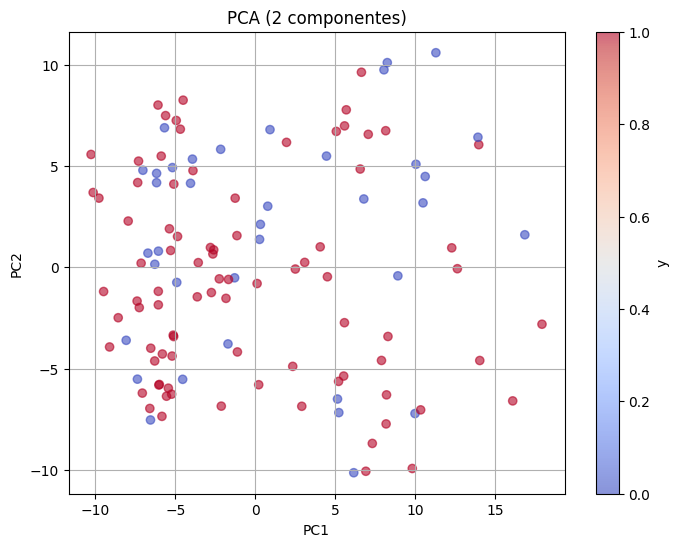

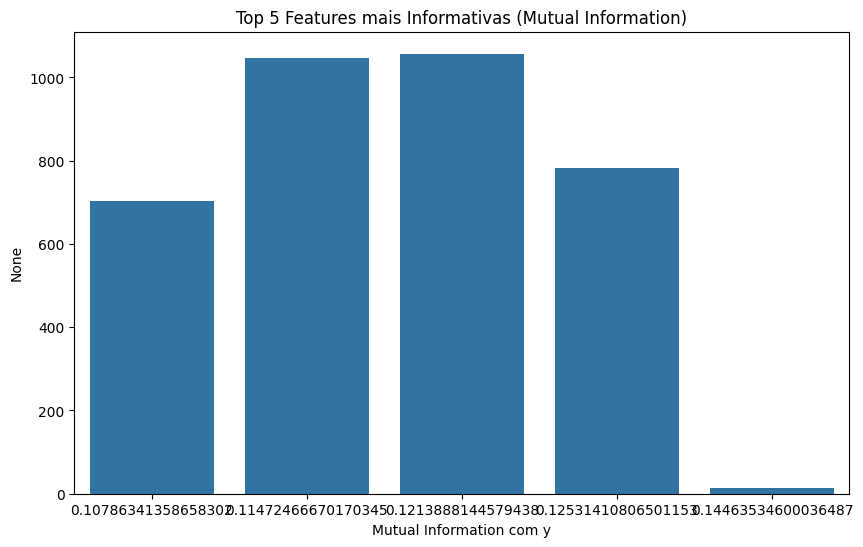

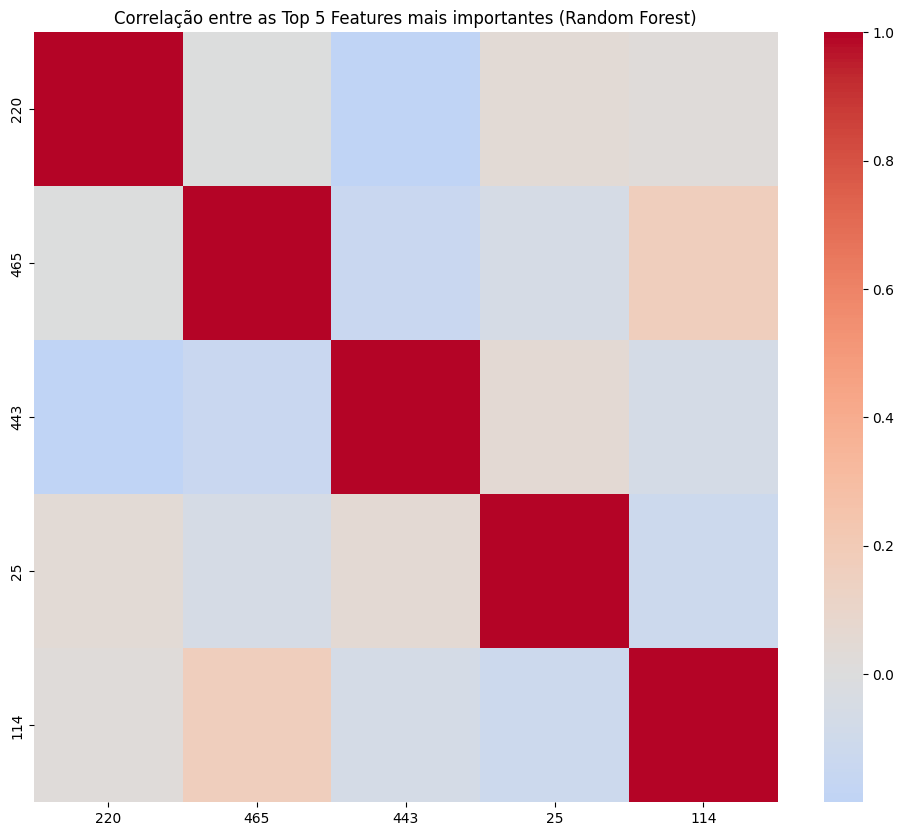

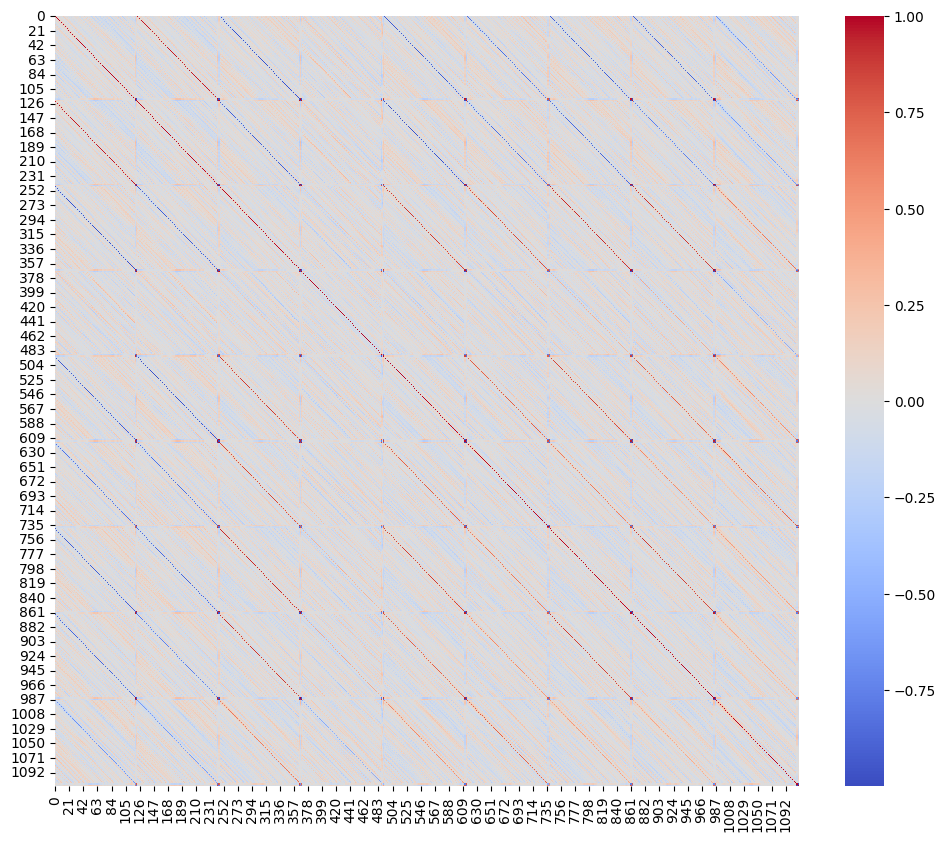

Matriz binario1: (242, 120)
Matriz binario1: (242, 124)
Matriz binario1: (242, 120)
Matriz binario1: (242, 124)
Matriz binario1: (242, 120)
Matriz binario2: (242, 124)
Matriz binario1: (242, 120)
Matriz binario2: (242, 124)
Matriz binario1: (242, 120)
Matriz binario3: (242, 124)
(242, 1112) (242, 1)


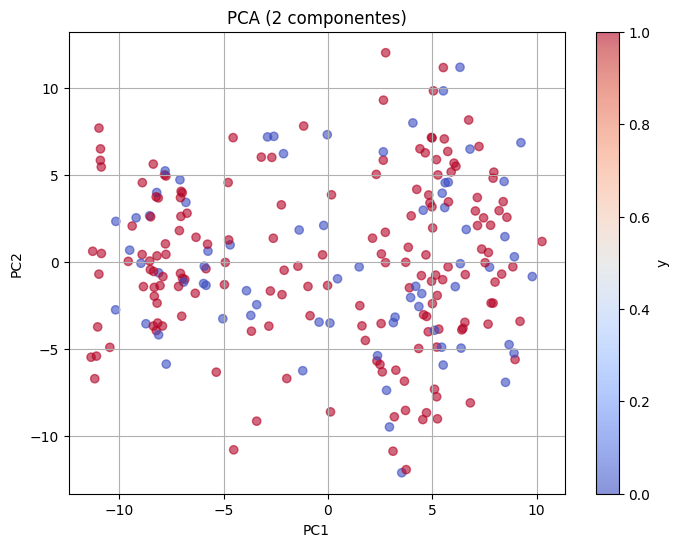

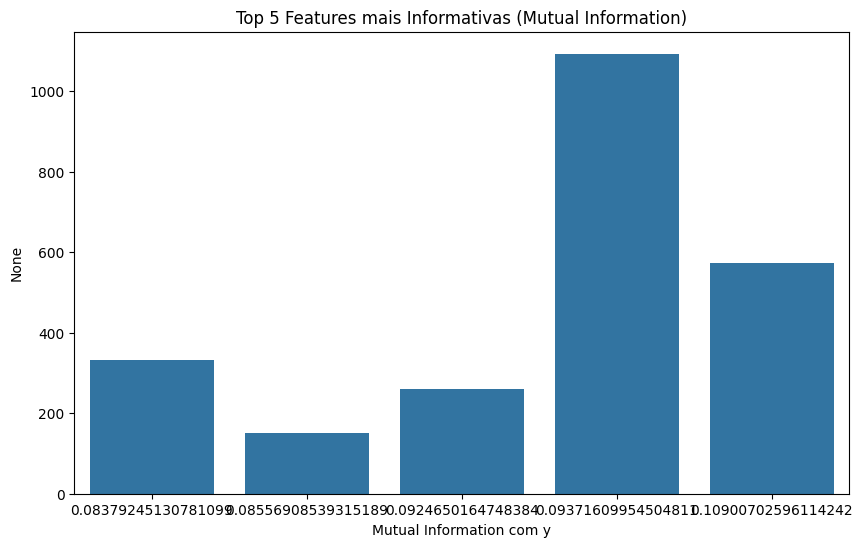

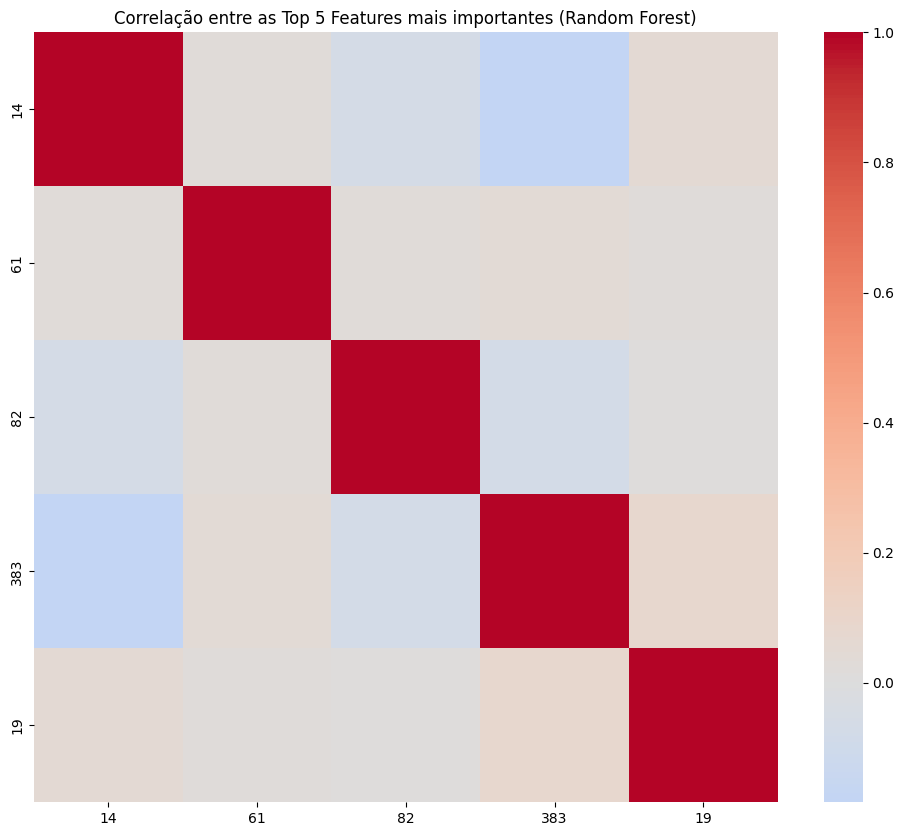

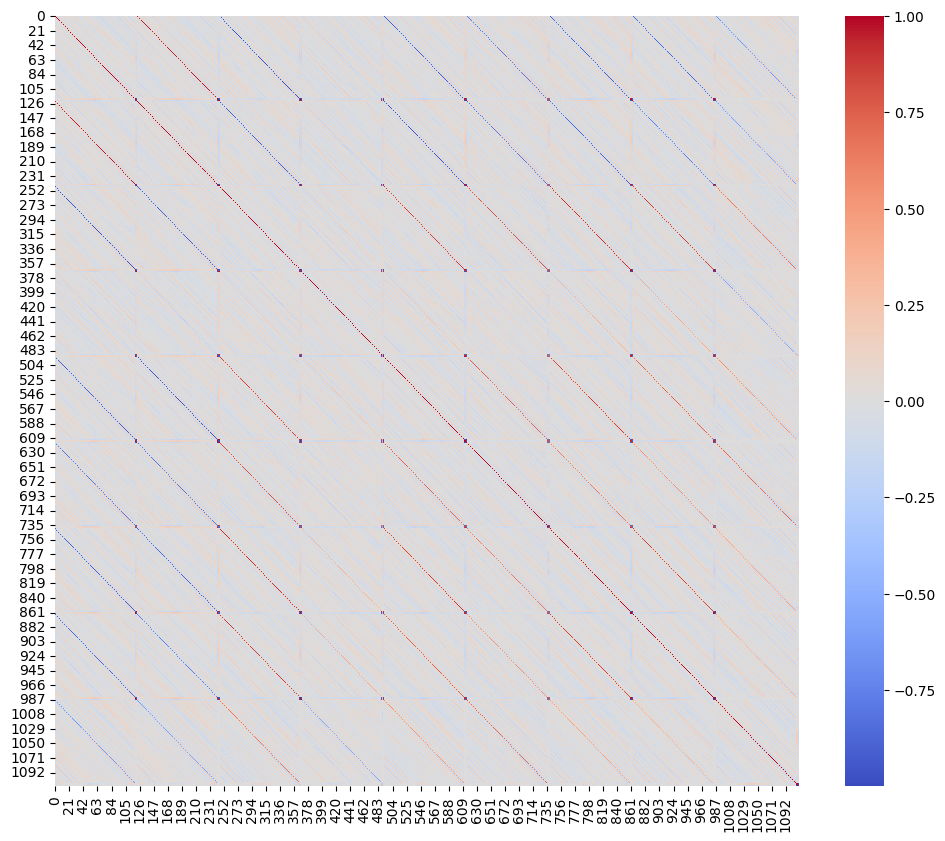

Matriz binario1: (362, 120)
Matriz binario1: (362, 124)
Matriz binario1: (362, 120)
Matriz binario1: (362, 124)
Matriz binario1: (362, 120)
Matriz binario2: (362, 124)
Matriz binario1: (362, 120)
Matriz binario2: (362, 124)
Matriz binario1: (362, 120)
Matriz binario3: (362, 124)
(362, 1112) (362, 1)


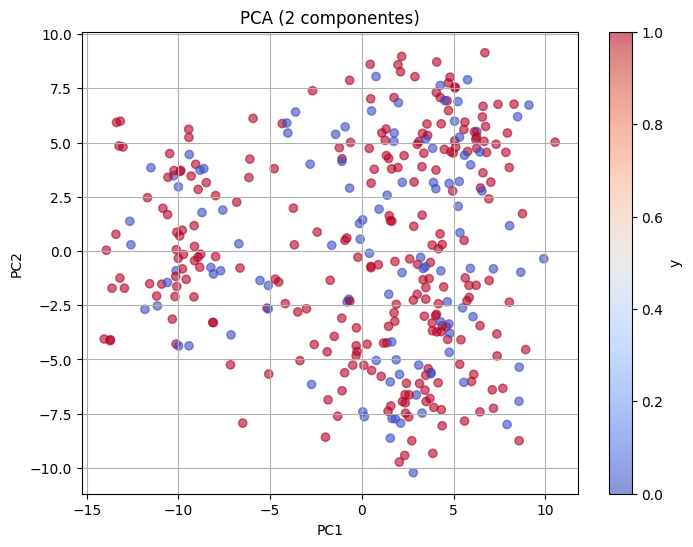

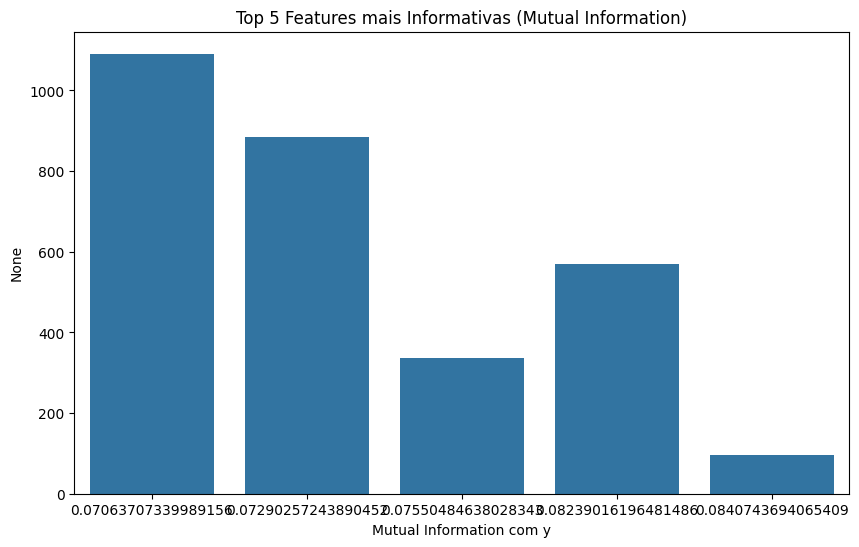

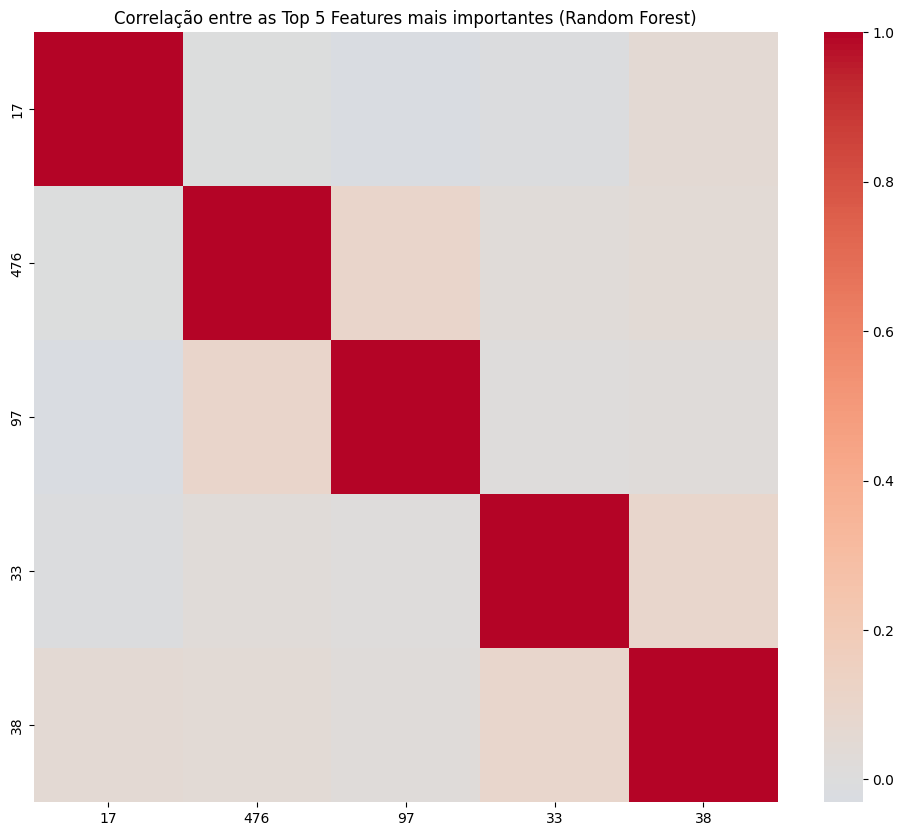

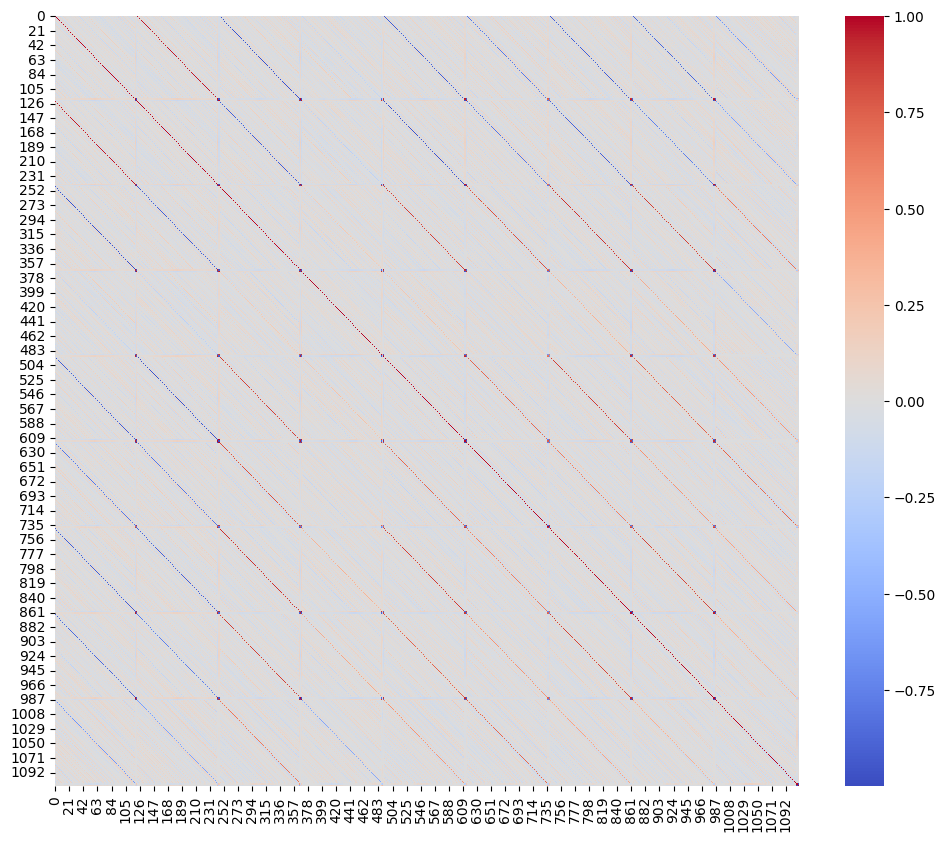

Matriz binario1: (482, 120)
Matriz binario1: (482, 124)
Matriz binario1: (482, 120)
Matriz binario1: (482, 124)
Matriz binario1: (482, 120)
Matriz binario2: (482, 124)
Matriz binario1: (482, 120)
Matriz binario2: (482, 124)
Matriz binario1: (482, 120)
Matriz binario3: (482, 124)
(482, 1112) (482, 1)


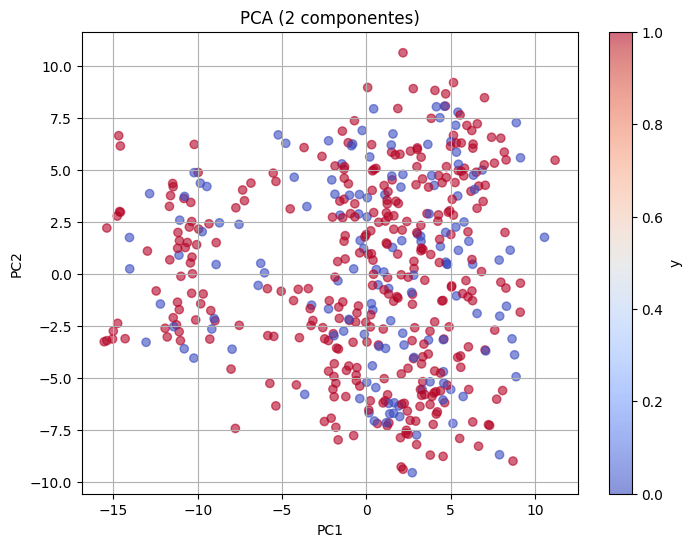

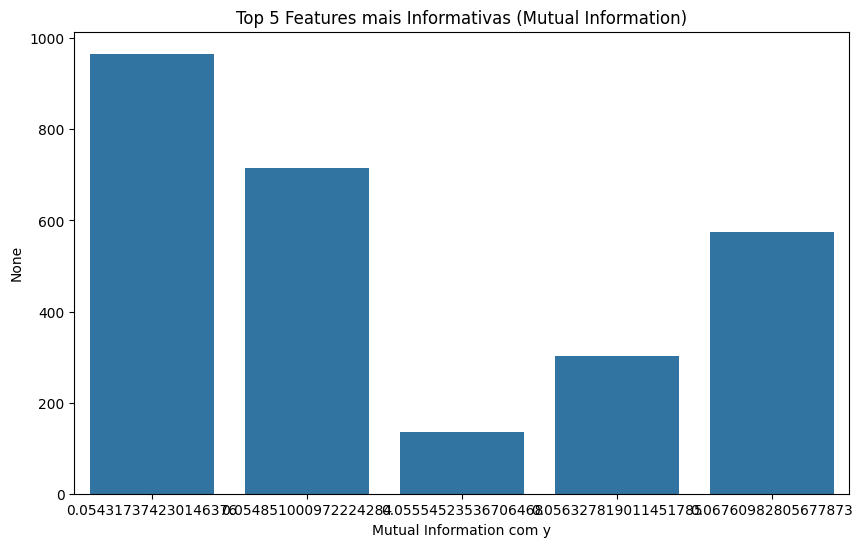

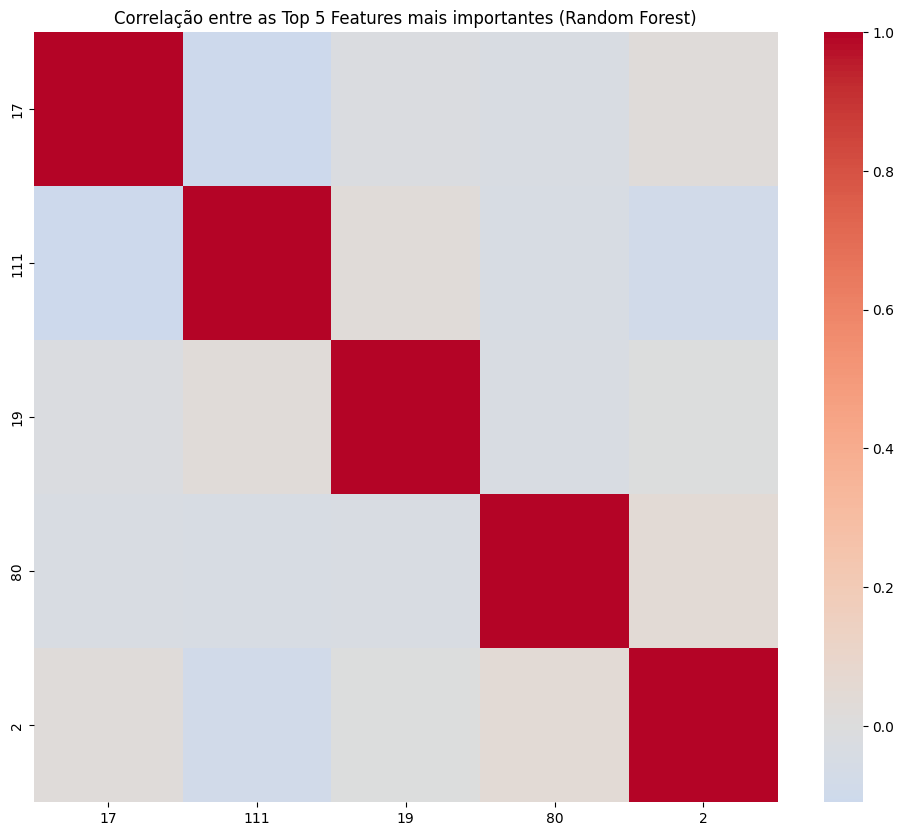

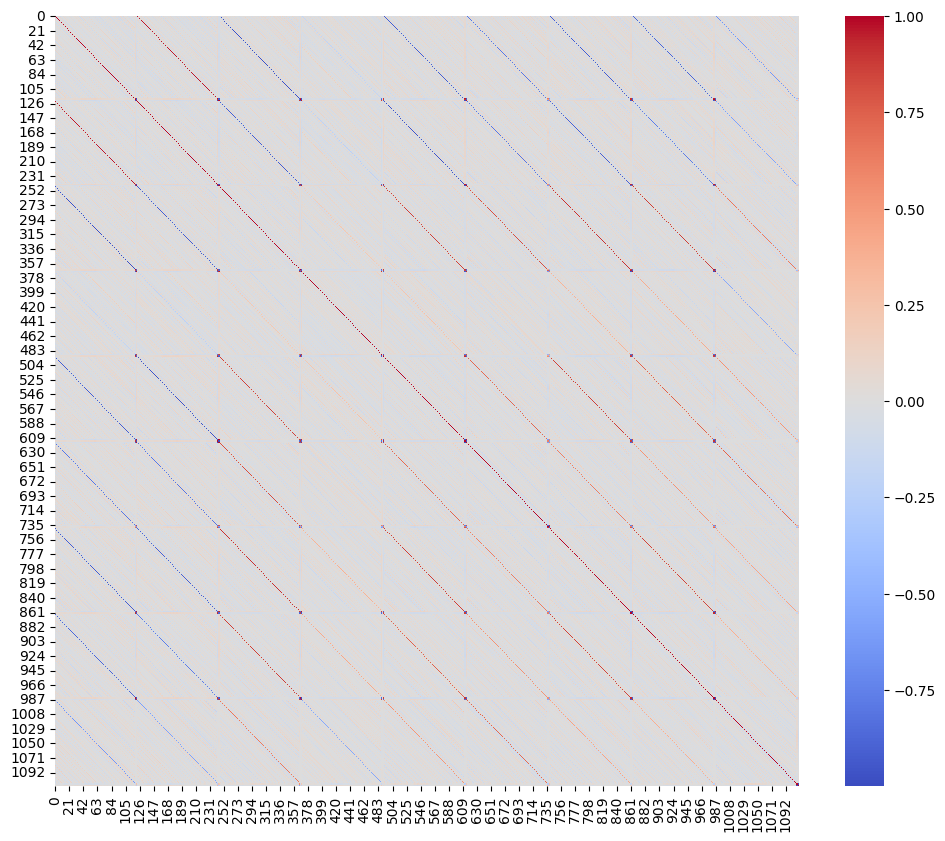

In [17]:
array = []
vetor = AjustesOdds(array)
for i in range(0, 720):
    array_ajuste, odd = vetor.coletarodd(i, 720, data)
    if i >= 240 and (i % 120 == 0):
        matriz1, matriz2 = vetor.tranforsmar_final_matriz(array_ajuste)
        print(matriz1.shape, matriz2.shape)
        # Etapa 1: Preparação
        X = pd.DataFrame(matriz1)
        y = matriz2.flatten()

        # Etapa 2: Correlação das features com y (usando Mutual Information)
        mi = mutual_info_classif(X, y, discrete_features='auto')
        mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

        # Etapa 3: Importância via Random Forest
        rf = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42)
        rf.fit(X, y)
        importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

        # Etapa 4: Correlação entre as próprias features (matriz de correlação)
        corr_matrix = X.corr()
        #print(corr_matrix)

        # Etapa 5: Redução de dimensionalidade via PCA
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)

        # Plot: 2D PCA
        plt.figure(figsize=(8, 6))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6)
        plt.title('PCA (2 componentes)')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.colorbar(label='y')
        plt.grid(True)
        plt.show()

        # Plot: Heatmap das top 5 correlações com y
        top_mi = mi_series.head(5)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=top_mi.values, y=top_mi.index)
        plt.title('Top 5 Features mais Informativas (Mutual Information)')
        plt.xlabel('Mutual Information com y')
        plt.show()

        # Plot: Heatmap de correlação entre features (top 5 mais importantes por RF)
        top_rf = importances.head(5).index
        plt.figure(figsize=(12, 10))
        sns.heatmap(X[top_rf].corr(), annot=False, cmap='coolwarm', center=0)
        plt.title('Correlação entre as Top 5 Features mais importantes (Random Forest)')
        plt.show()

        # Plot: Importância das principais variáveis
        plt.figure(figsize=(12,10)) 
        sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
        plt.show()
    


In [18]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

Matriz binario1: (122, 120)
Matriz binario1: (122, 124)
Matriz binario1: (122, 120)
Matriz binario1: (122, 124)
Matriz binario1: (122, 120)
Matriz binario2: (122, 124)
Matriz binario1: (122, 120)
Matriz binario2: (122, 124)
Matriz binario1: (122, 120)
Matriz binario3: (122, 124)
(122, 1112) (122, 1)
Modelo Linear - Regressão Logística
              precision    recall  f1-score   support

           0       0.25      0.29      0.27         7
           1       0.71      0.67      0.69        18

    accuracy                           0.56        25
   macro avg       0.48      0.48      0.48        25
weighted avg       0.58      0.56      0.57        25

Modelo Não Linear - Random Forest
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.72      1.00      0.84        18

    accuracy                           0.72        25
   macro avg       0.36      0.50      0.42        25
weighted avg       0.52      0

/home/darkcover/.cache/pypoetry/virtualenvs/out-idYdofvy-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darkcover/.cache/pypoetry/virtualenvs/out-idYdofvy-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darkcover/.cache/pypoetry/virtualenvs/out-idYdofvy-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

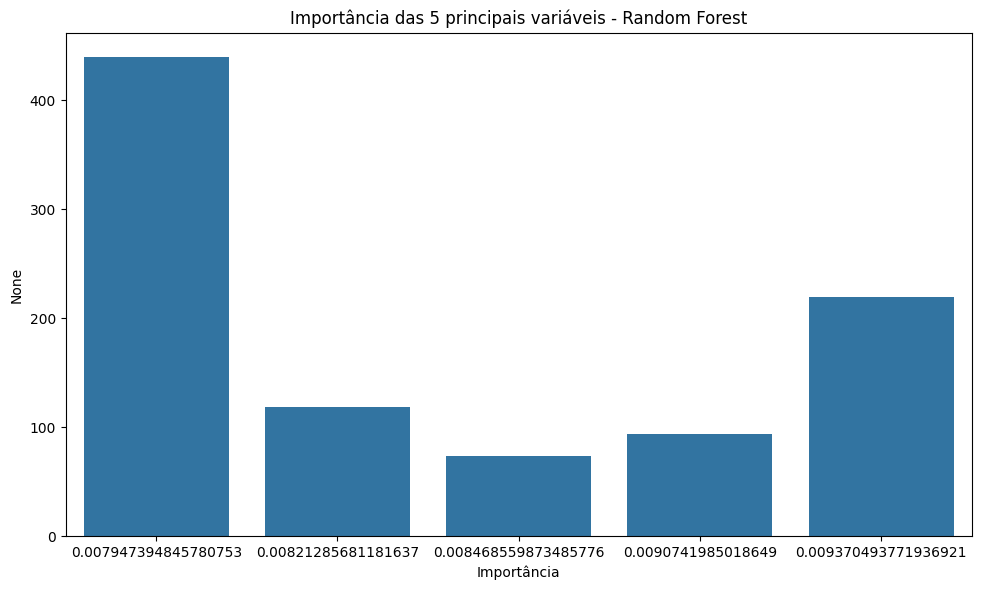

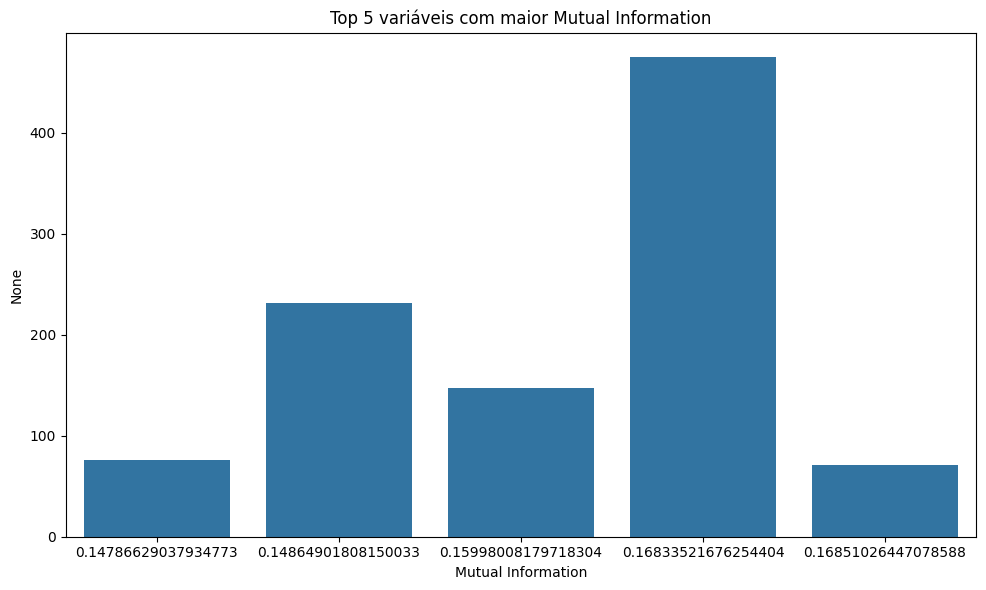

Matriz binario1: (242, 120)
Matriz binario1: (242, 124)
Matriz binario1: (242, 120)
Matriz binario1: (242, 124)
Matriz binario1: (242, 120)
Matriz binario2: (242, 124)
Matriz binario1: (242, 120)
Matriz binario2: (242, 124)
Matriz binario1: (242, 120)
Matriz binario3: (242, 124)
(242, 1112) (242, 1)
Modelo Linear - Regressão Logística
              precision    recall  f1-score   support

           0       0.36      0.25      0.30        16
           1       0.68      0.79      0.73        33

    accuracy                           0.61        49
   macro avg       0.52      0.52      0.51        49
weighted avg       0.58      0.61      0.59        49

Modelo Não Linear - Random Forest
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.67      1.00      0.80        33

    accuracy                           0.67        49
   macro avg       0.34      0.50      0.40        49
weighted avg       0.45      0

/home/darkcover/.cache/pypoetry/virtualenvs/out-idYdofvy-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darkcover/.cache/pypoetry/virtualenvs/out-idYdofvy-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darkcover/.cache/pypoetry/virtualenvs/out-idYdofvy-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

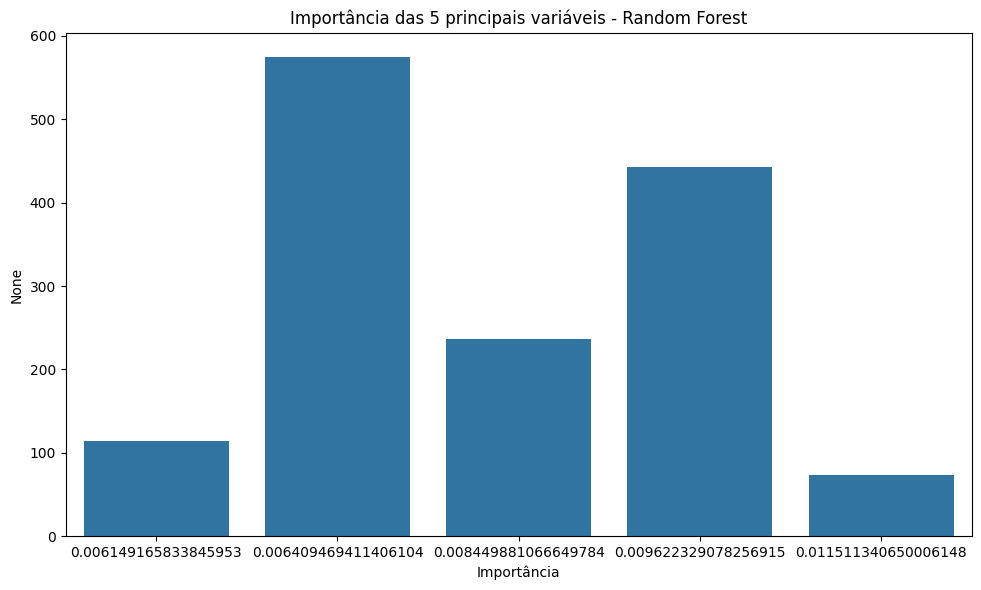

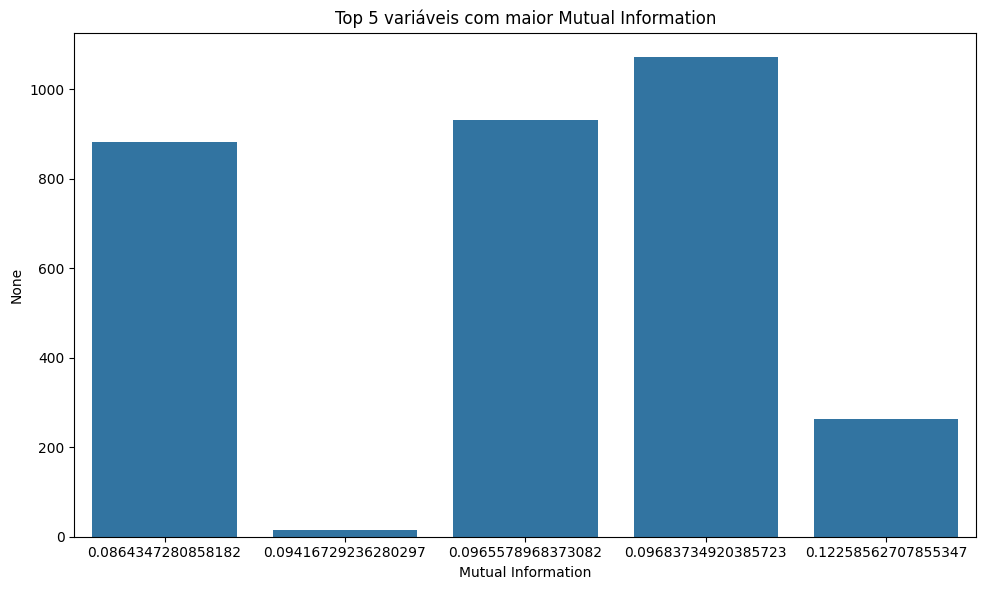

Matriz binario1: (362, 120)
Matriz binario1: (362, 124)
Matriz binario1: (362, 120)
Matriz binario1: (362, 124)
Matriz binario1: (362, 120)
Matriz binario2: (362, 124)
Matriz binario1: (362, 120)
Matriz binario2: (362, 124)
Matriz binario1: (362, 120)
Matriz binario3: (362, 124)
(362, 1112) (362, 1)
Modelo Linear - Regressão Logística
              precision    recall  f1-score   support

           0       0.22      0.17      0.20        23
           1       0.65      0.72      0.69        50

    accuracy                           0.55        73
   macro avg       0.44      0.45      0.44        73
weighted avg       0.52      0.55      0.53        73

Modelo Não Linear - Random Forest
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.68      1.00      0.81        50

    accuracy                           0.68        73
   macro avg       0.34      0.50      0.41        73
weighted avg       0.47      0

/home/darkcover/.cache/pypoetry/virtualenvs/out-idYdofvy-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darkcover/.cache/pypoetry/virtualenvs/out-idYdofvy-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darkcover/.cache/pypoetry/virtualenvs/out-idYdofvy-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

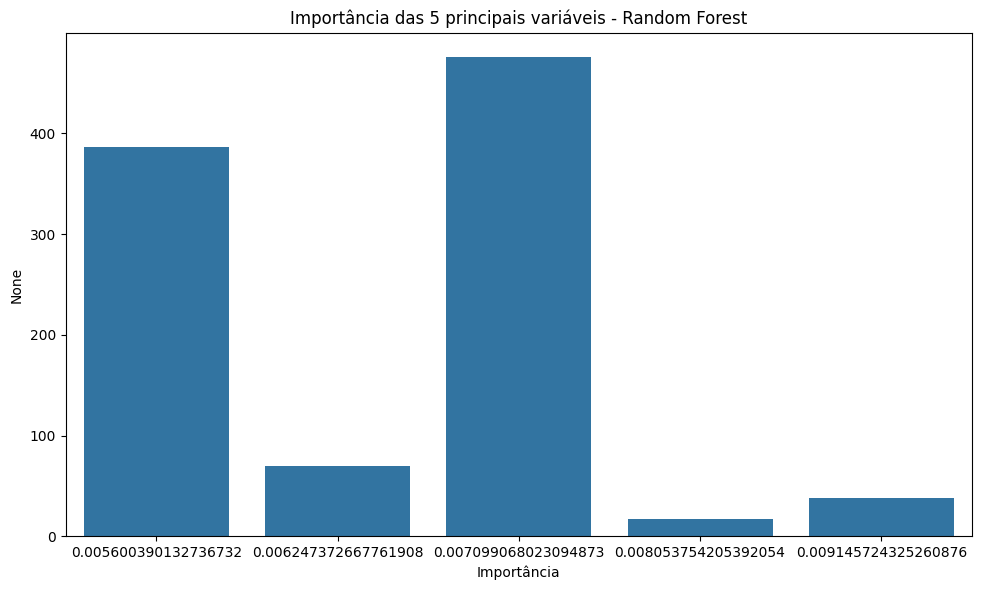

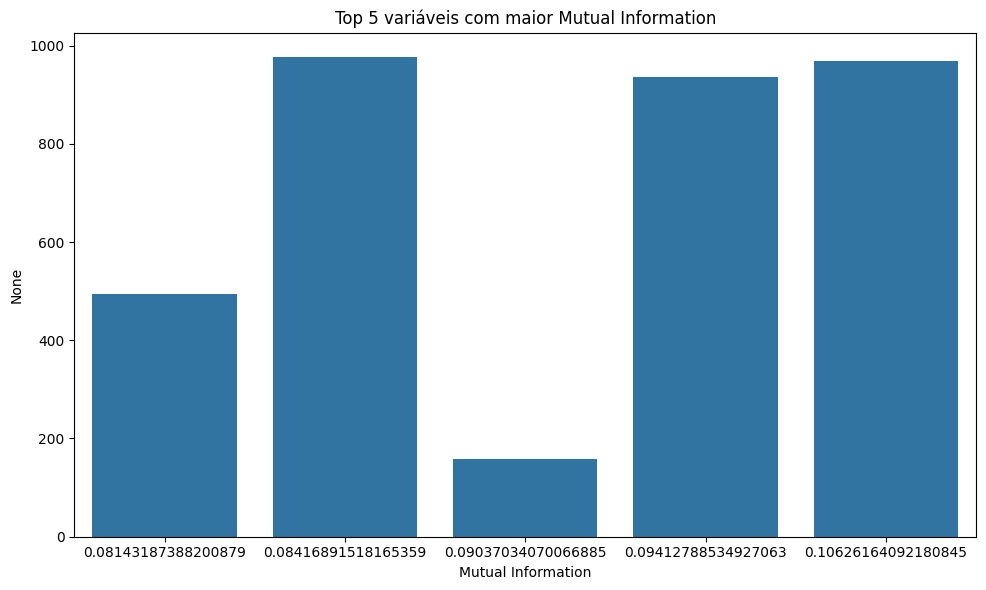

Matriz binario1: (482, 120)
Matriz binario1: (482, 124)
Matriz binario1: (482, 120)
Matriz binario1: (482, 124)
Matriz binario1: (482, 120)
Matriz binario2: (482, 124)
Matriz binario1: (482, 120)
Matriz binario2: (482, 124)
Matriz binario1: (482, 120)
Matriz binario3: (482, 124)
(482, 1112) (482, 1)
Modelo Linear - Regressão Logística
              precision    recall  f1-score   support

           0       0.27      0.25      0.26        28
           1       0.70      0.72      0.71        69

    accuracy                           0.59        97
   macro avg       0.49      0.49      0.49        97
weighted avg       0.58      0.59      0.58        97

Modelo Não Linear - Random Forest
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.71      1.00      0.83        69

    accuracy                           0.71        97
   macro avg       0.36      0.50      0.42        97
weighted avg       0.51      0

/home/darkcover/.cache/pypoetry/virtualenvs/out-idYdofvy-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darkcover/.cache/pypoetry/virtualenvs/out-idYdofvy-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darkcover/.cache/pypoetry/virtualenvs/out-idYdofvy-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

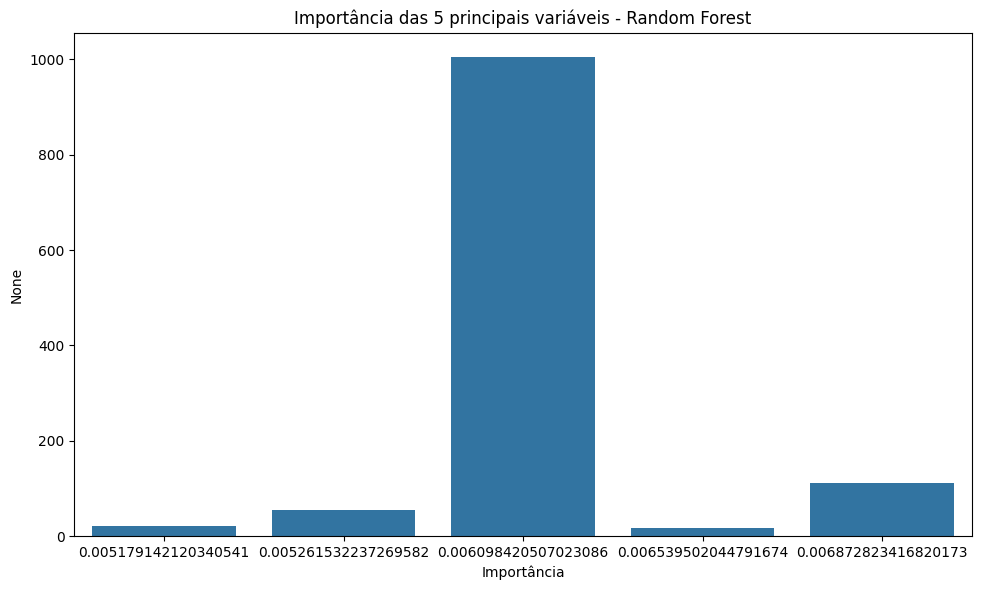

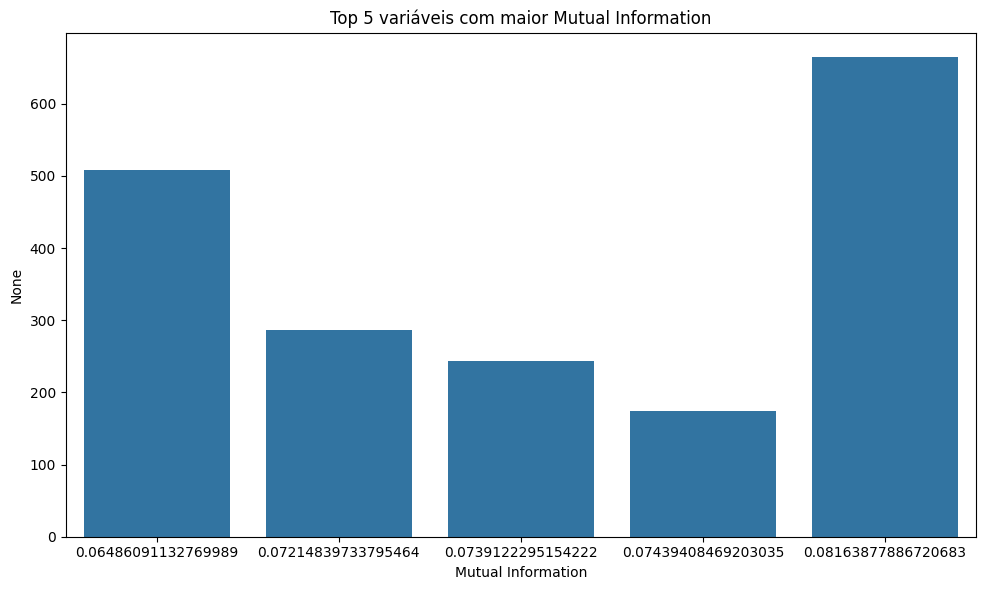

In [19]:
array = []
vetor = AjustesOdds(array)
for i in range(0, 720):
    array_ajuste, odd = vetor.coletarodd(i, 720, data)
    if i >= 240 and (i % 120 == 0):
        matriz1, matriz2 = vetor.tranforsmar_final_matriz(array_ajuste)
        print(matriz1.shape, matriz2.shape)

        # 1. Pré-processamento
        # Supondo que você já tenha X_final (matriz com shape [n_amostras, n_features]) e y_final (vetor binário)

        X = pd.DataFrame(matriz1)  # suas features
        y = matriz2.flatten()      # saída binária

        # 2. Divisão treino/teste
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 3. Modelo linear base (regressão logística)
        logreg = LogisticRegression(max_iter=1000)
        logreg.fit(X_train, y_train)
        y_pred_lr = logreg.predict(X_test)

        print("Modelo Linear - Regressão Logística")
        print(classification_report(y_test, y_pred_lr))

        # 4. Modelo não linear (Random Forest)
        rf = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42)
        rf.fit(X_train, y_train)
        y_pred_rf = rf.predict(X_test)

        print("Modelo Não Linear - Random Forest")
        print(classification_report(y_test, y_pred_rf))

        # 5. Importância das features via Random Forest
        importances = pd.Series(rf.feature_importances_, index=X.columns)
        top_features = importances.sort_values(ascending=False).head(5)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=top_features.values, y=top_features.index)
        plt.title("Importância das 5 principais variáveis - Random Forest")
        plt.xlabel("Importância")
        plt.tight_layout()
        plt.show()

        # 6. Mutual Information
        mi = mutual_info_classif(X_train, y_train)
        mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False).head(5)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=mi_series.values, y=mi_series.index)
        plt.title("Top 5 variáveis com maior Mutual Information")
        plt.xlabel("Mutual Information")
        plt.tight_layout()
        plt.show()
